# Bias Amplification

See: https://proceedings.mlr.press/v139/wang21t/wang21t.pdf for details.

This notebook contains a demo of Directed Bias Amplification, and shows why Absolute Bias Amplification rather than the directed version is a better candidate for direct optimization.

We compute the form of Bias Amplification that moves from protected attributes A to target values T; as we are interested in the bias of a classifier that predicts T.

The TL;DR of this notebook is to minimize the absolute measure `group_metrics.bias_amplification` even if you are interested in measuring `group_metrics.directed_bias_amplification`.

In [1]:
# Load data and train a baseline classifier

from oxonfair import dataset_loader, FairPredictor
from oxonfair import group_metrics as gm
import xgboost
import pandas as pd
import numpy as np


train_data, val_data, test_data = dataset_loader.adult('sex',seed=0)
predictor=xgboost.XGBClassifier().fit(X=train_data['data'],y=train_data['target'])

In [2]:
# Modify predictor to enforce fairness over the val_data with respect to groups given by the column 'sex'. 
# Note that 'sex' is implied because the dataset loader creates DataDict with val_data['groups' ]='sex'
fpredictor = FairPredictor(predictor,val_data)

In [3]:
# We can now compute the bias amplification for the existing predictor
fpredictor.evaluate_groups(metrics={'a': gm.directed_bias_amplification})

Directed Bias Amplification
         Groups                                         
original Overall                                0.037510
         0                                     -0.022727
         1                                      0.044842
         Maximum difference                     0.067569
updated  Overall                                0.037510
         0                                     -0.022727
         1                                      0.044842
         Maximum difference                     0.067569

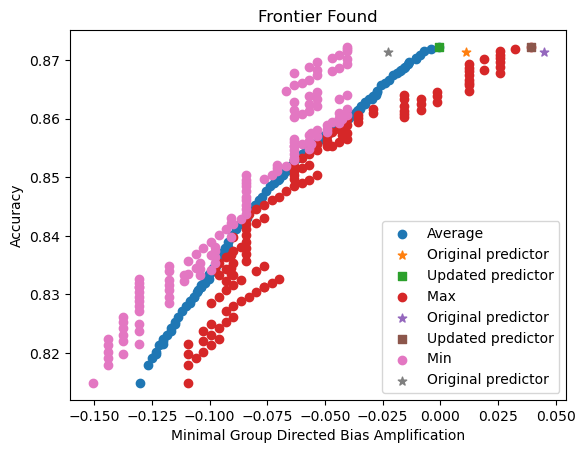

In [4]:
# Weng et al., defines the total directed bias amplification as it's average
fpredictor.fit(gm.accuracy, gm.directed_bias_amplification.average,0)
# and plotting the pareto frontier along with how the maximal and minimal directed bias amplification varies, we see
# that while decreasing it eventually results in the per group directed bias amplification coinciding.
# we actually want it to be close to zero for both groups
fpredictor.plot_frontier(name_frontier='Average')
fpredictor.plot_frontier(objective2=gm.directed_bias_amplification.max,name_frontier='Max ',new_plot=False)
fpredictor.plot_frontier(objective2=gm.directed_bias_amplification.min,new_plot=False,show_original=True,show_updated=False,name_frontier='Min ')

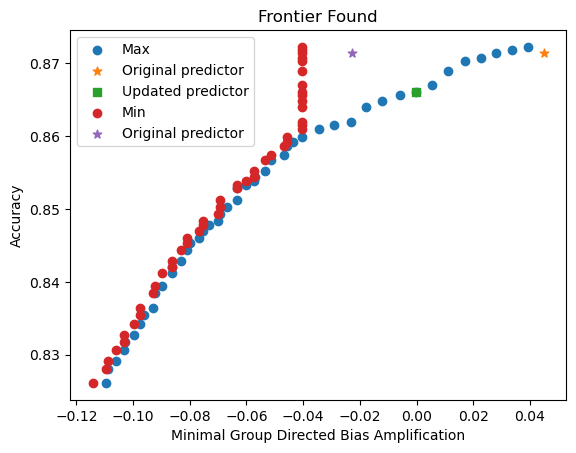

In [5]:
# We can enforce fairness by decreasing the maximal directed bias amplification to zero
fpredictor.fit(gm.accuracy,gm.directed_bias_amplification.max,0)
# and plotting the pareto frontier along with how the maximal and minimal directed bias amplification varies, we see
# that while decreasing it eventually results in the per group directed bias amplification coinciding.
# we actually want it to be close to zero for both groups
fpredictor.plot_frontier(objective2=gm.directed_bias_amplification.max,name_frontier='Max')
fpredictor.plot_frontier(objective2=gm.directed_bias_amplification.min,new_plot=False,show_original=True,show_updated=False,name_frontier='Min')

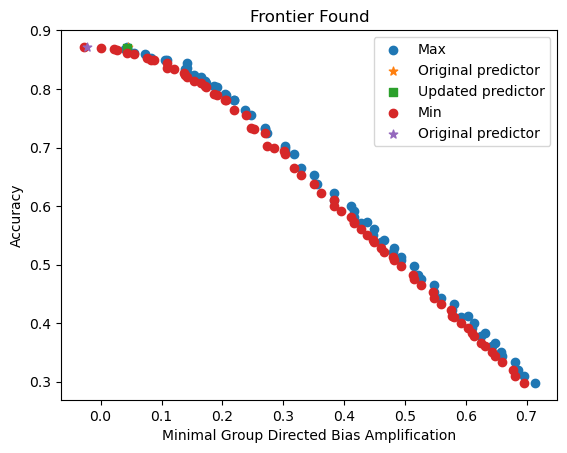

In [6]:
# A similar patten occurs when maximising min,
# Although it is harder to see.
fpredictor.fit(gm.accuracy,gm.directed_bias_amplification.min,0)
fpredictor.plot_frontier(objective2=gm.directed_bias_amplification.max,name_frontier='Max')
fpredictor.plot_frontier(objective2=gm.directed_bias_amplification.min,new_plot=False,show_original=True,show_updated=False,name_frontier='Min')

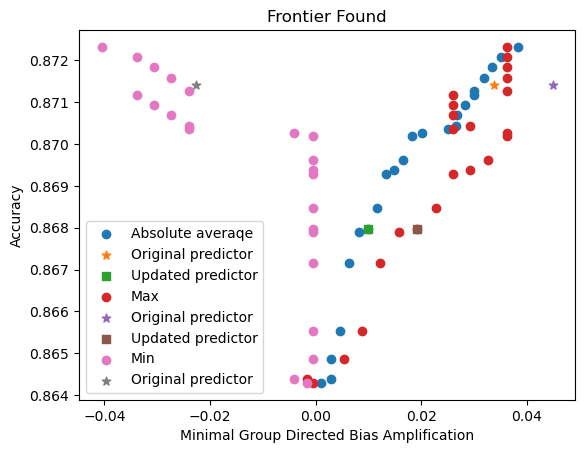

In [8]:
# Instead we minimize the average of the absolute value
# Although these plots are much noiser - due to unstable measures and on limited data
# We see that we are able to get bias amplification close to zero for each group.
fpredictor.fit(gm.accuracy,gm.bias_amplification.average,0.01) # The lumpy grid size is an artifact of small data. 
# Setting grid_width=500 doesn't improve things
fpredictor.plot_frontier(name_frontier='Absolute averaqe')
fpredictor.plot_frontier(objective2=gm.directed_bias_amplification.max,name_frontier='Max',new_plot=False)
fpredictor.plot_frontier(objective2=gm.directed_bias_amplification.min,new_plot=False,show_original=True,show_updated=False,name_frontier='Min')